<a href="https://colab.research.google.com/github/Devu-Goyal/Chinese_Social_Media_Towards_Vaccine/blob/main/Chinese_Social_Media_Towards_Vaccine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline 
from wordcloud import WordCloud, STOPWORDS
from joblib import Parallel, delayed
import tqdm
import jieba
import time
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, recall_score

In [74]:
data = pd.read_csv("/content/chinese_news.csv")

In [75]:
data.head(10)    

,date,tag,headline,content
0,2016-01-01,详细全文,陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队...,中国人民解放军陆军领导机构、中国人民解放军火箭军、中国人民解放军战略支援部队成立大会2015...
1,2016-01-01,详细全文,中央军委印发《关于深化国防和军队改革的意见》,经中央军委主席习近平批准，中央军委近日印发了《关于深化国防和军队改革的意见》。\n《意见》强...
2,2016-01-01,详细全文,《习近平关于严明党的纪律和规矩论述摘编》出版发行,由中共中央纪律检查委员会、中共中央文献研究室编辑的《习近平关于严明党的纪律和规矩论述摘编》一...
3,2016-01-01,详细全文,以实际行动向党中央看齐 向高标准努力,广大党员干部正在积极学习习近平总书记在中央政治局专题民主生活会上的重要讲话。大家纷纷表示要把...
4,2016-01-01,详细全文,【年终特稿】关键之年 改革挺进深水区,刚刚过去的2015年，是全面深化改革的关键之年。改革集中发力在制约经济社会发展的深层次矛盾，...
5,2016-01-01,详细全文,【2016 我们来了！】全国各地举行2016新年倒计时活动,点燃欢庆的焰火，许下祈福的心愿，敲响希望的钟声。在辞旧迎新时刻，我国各地及世界各国民众以多种...
6,2016-01-01,详细全文,【2016 我们来了！】世界各国多种形式喜迎2016年,澳大利亚是全球最先迎来新年的国家之一，悉尼海港大桥的烟花表演已经是延续多年的跨年传统活动，今...
7,2016-01-02,详细全文,【年终特稿】依法治国按下“快进键”,2015年是“全面推进依法治国”的开局之年，习近平总书记提出“要全面推进依法治国，更好维...
8,2016-01-02,详细全文,新年贺卡——一年感恩 一路有你,有付出，就会有收获。只要坚持，梦想总是可以实现的。新年伊始，每个人都对未来有着美好的憧憬...
9,2016-01-02,详细全文,【这一年，什么让你最愧疚?】,陈研：我最初出来的时候，我在想一年四季，每个季节回去一次看看父母，后来都没有实现。\n高峻驰...


In [76]:
data.shape

(20738, 4)

In [77]:
print("Null Content data -:")
print(data.loc[data['content'].isnull()].shape) 
# we have to eleminate where main output data is null, i.e. no textual data-content, to make our tags healthy
data = data.loc[~data['content'].isnull()]
print("New data -:")
data.shape

Null Content data -:
(107, 4)
New data -:


(20631, 4)

In [78]:
import matplotlib.font_manager as fm
font_path = '/content/SourceHanSansCN-Regular.otf'
prop = fm.FontProperties(fname=font_path)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


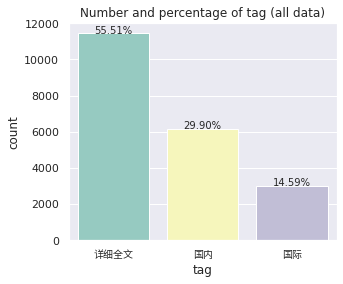

In [79]:
def plot_count(feature, title, df, font_prop=prop, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:20], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font_prop);
    plt.show()    

plot_count('tag', 'tag (all data)', font_prop=prop, df=data, size=1.2)

In [80]:
data['datetime'] = data['date'].apply(lambda x: pd.to_datetime(x))
data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['dayofweek'] = data['datetime'].dt.dayofweek

In [81]:
def jieba_cut(x, sep=' '):
    return sep.join(jieba.cut(x, cut_all=False))

print('raw', data['headline'][0])
print('cut', jieba_cut(data['headline'][0], ', '))

raw 陆军领导机构火箭军战略支援部队成立大会在京举行 习近平向中国人民解放军陆军火箭军战略支援部队授予军旗并致训词
cut 陆军, 领导, 机构, 火箭, 军, 战略, 支援, 部队, 成立, 大会, 在京举行,  , 习近平, 向, 中国人民解放军, 陆军, 火箭, 军, 战略, 支援, 部队, 授予, 军旗, 并致, 训词


In [82]:
%%time
data['headline_cut'] = Parallel(n_jobs=4)(
    delayed(jieba_cut)(x) for x in tqdm.tqdm_notebook(data['headline'].values)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20631 [00:00<?, ?it/s]

CPU times: user 1.79 s, sys: 150 ms, total: 1.94 s
Wall time: 8.96 s


In [83]:
%%time
data['content_cut'] = Parallel(n_jobs=4)(
    delayed(jieba_cut)(x) for x in tqdm.tqdm_notebook(data['content'].values)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/20631 [00:00<?, ?it/s]

CPU times: user 6.2 s, sys: 290 ms, total: 6.49 s
Wall time: 48.3 s


In [84]:
prop = fm.FontProperties(fname=font_path, size=20)
print(prop)

sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:file=/content/SourceHanSansCN-Regular.otf:size=20.0


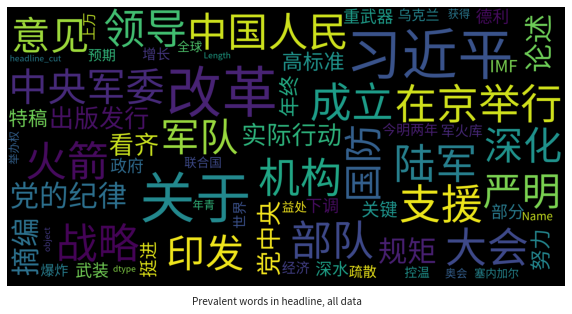

In [85]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, font_path=font_path, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        font_path=font_path,
        max_words=100,
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10,9))
    plt.axis('off')
    if title: 
        prop = fm.FontProperties(fname=font_path)
        fig.suptitle(title, fontsize=40, fontproperties=prop)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(data['headline_cut'], font_path, title = 'Prevalent words in headline, all data')

In [86]:
data.tag.unique()
# on how many tags do we have to work on

array(['详细全文', '国内', '国际'], dtype=object)

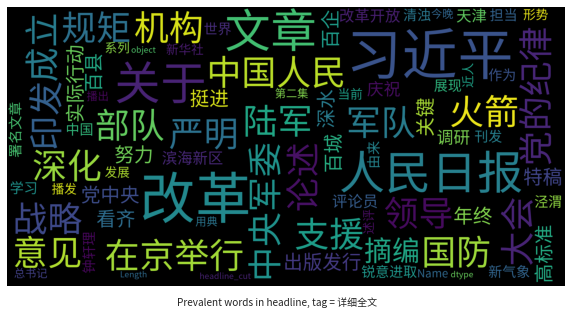

In [87]:
# word cloud for tag -: 详细全文
data_tag = data.loc[data.tag=='详细全文']
show_wordcloud(data_tag['headline_cut'], font_path, title = 'Prevalent words in headline, tag = 详细全文')

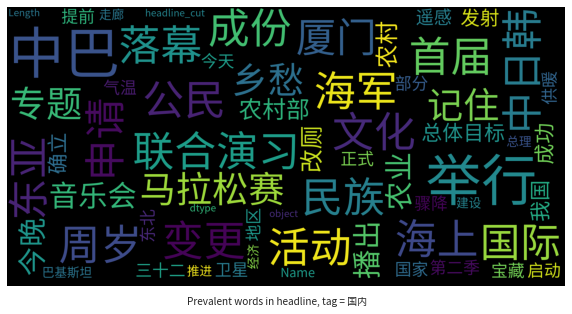

In [88]:
# word cloud for tag -: 国内
data_tag = data.loc[data.tag=='国内']
show_wordcloud(data_tag['headline_cut'], font_path, title = 'Prevalent words in headline, tag = 国内')

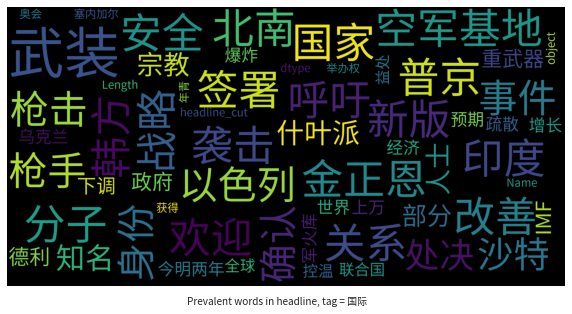

In [89]:
# word cloud for tag -: 国际
data_tag = data.loc[data.tag=='国际']
show_wordcloud(data_tag['headline_cut'], font_path, title = 'Prevalent words in headline, tag = 国际')

# **Splitting dataset to training set and testing set**

In [90]:
train, test = train_test_split(data, test_size = 0.3, random_state = 1)
print(f"train: {train.shape}, test: {test.shape}")


train: (14441, 10), test: (6190, 10)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


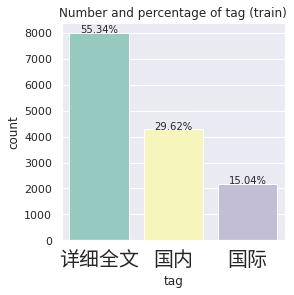

In [91]:
plot_count('tag', 'tag (train)', font_prop=prop, df=train, size=1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


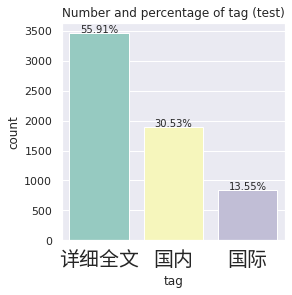

In [92]:
plot_count('tag', 'tag (test)', font_prop=prop, df=test, size=1)

In [93]:
train.head(5)

,date,tag,headline,content,datetime,year,month,dayofweek,headline_cut,content_cut
2136,2016-04-29,详细全文,【大国工匠 匠心传世】药丸三克 责任千斤,有一颗小药丸，它被中医奉为救命“神药”，有着213年的历史，时至今日依然沿袭着传统的手工制作...,2016-04-29,2016,4,4,【 大国 工匠 匠心 传世 】 药丸 三 克 责任 千斤,有 一颗 小 药丸 ， 它 被 中医 奉 为 救命 “ 神药 ” ， 有着 213 年 的 ...
20155,2018-09-11,详细全文,栗战书与金正恩再次会见并出席朝鲜为中国党政代表团举行的欢迎活动,9月10日，正在朝鲜访问的中共中央总书记、国家主席习近平特别代表，中共中央政治局常委、全国人...,2018-09-11,2018,9,1,栗 战书 与 金正恩 再次 会见 并 出席 朝鲜 为 中国 党政 代表团 举行 的 欢迎 活动,9 月 10 日 ， 正在 朝鲜 访问 的 中共中央 总书记 、 国家 主席 习近平 特别 ...
15915,2018-02-26,详细全文,【在习近平新时代中国特色社会主义思想指引下——新时代 新气象 新作为】新疆：凝心聚力 筑牢民...,习近平总书记在十九大报告中指出，铸牢中华民族共同体意识，加强各民族交往交流交融，促进各民族像...,2018-02-26,2018,2,0,【 在 习近平 新 时代 中国 特色 社会主义 思想 指引 下 — — 新 时代 新气象...,习近平 总书记 在 十九 大 报告 中 指出 ， 铸牢 中华民族 共同体 意识 ， 加强 各...
18565,2018-06-29,国际,印尼阿贡火山喷发 机场一度关闭,受到持续喷发的印度尼西亚巴厘岛阿贡火山影响，自当地时间29日凌晨起，巴厘岛上的伍拉莱国际机场...,2018-06-29,2018,6,4,印尼 阿贡 火山 喷发 机场 一度 关闭,受到 持续 喷发 的 印度尼西亚 巴厘岛 阿贡 火山 影响 ， 自 当地 时间 29 日 凌...
20004,2018-09-05,详细全文,习近平会见圣多美和普林西比总理,国家主席习近平5日在人民大会堂会见圣多美和普林西比总理特罗瓦达。\n习近平指出，中非合作论坛...,2018-09-05,2018,9,2,习近平 会见 圣多美和普林西比 总理,国家 主席 习近平 5 日 在 人民大会堂 会见 圣多美和普林西比 总理 特罗 瓦达 。 \...


In [94]:
def count_vect_feature(feature, df, max_features=5000):
    start_time = time.time()
    cv = CountVectorizer(max_features=max_features,
                             ngram_range=(1, 1),
                             stop_words='english')
    X_feature = cv.fit_transform(df[feature])
    print('Count Vectorizer `{}` completed in {} sec.'.format(feature, round(time.time() - start_time,2)))
    return X_feature, cv
  
X_headline, cv = count_vect_feature('headline_cut', train, 20000)
X_content, cv = count_vect_feature('content_cut', train, 30000)

Count Vectorizer `headline_cut` completed in 0.23 sec.
Count Vectorizer `content_cut` completed in 2.09 sec.


In [95]:
target =  'tag'
x = X_content
y = train[target].values
train_X, valid_X, train_y, valid_y = train_test_split(x, y, test_size = 0.3, random_state = 1) 

train_X.shape, valid_X.shape, train_y.shape, valid_y.shape

((10108, 30000), (4333, 30000), (10108,), (4333,))

# **Using SVC**

In [96]:
# Model Fitting
clf_svc = SVC(kernel='linear')
clf_svc = clf_svc.fit(train_X, train_y)

Valid:
Feature: tag 	| Prediction accuracy: 0.7989845372720978
Feature: tag 	| Prediction F1-score: 0.8014765777317561
Feature: tag 	| Prediction recall: 0.7989845372720978


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22269 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38469 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35814 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32454 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20840 missing from current font.
  font.set_

<Figure size 432x432 with 0 Axes>

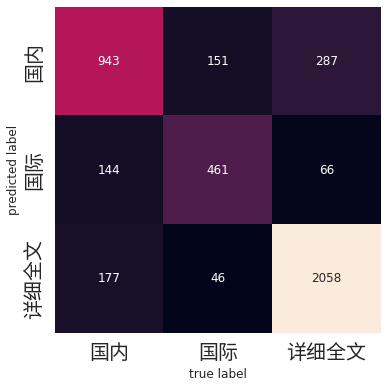

              precision    recall  f1-score   support

          国内       0.68      0.75      0.71      1264
          国际       0.69      0.70      0.69       658
        详细全文       0.90      0.85      0.88      2411

    accuracy                           0.80      4333
   macro avg       0.76      0.77      0.76      4333
weighted avg       0.81      0.80      0.80      4333



In [97]:
# Validation
def show_confusion_matrix(valid_y, predicted, size=1, font_prop=prop, trim_labels=False):
    mat = confusion_matrix(valid_y, predicted)
    plt.figure(figsize=(4*size, 4*size))
    f, ax = plt.subplots(1,1, figsize=(4*size,4*size))
    sns.set()
    target_labels = np.unique(valid_y)
    if(trim_labels):
        target_labels = [x[0:70] for x in target_labels]
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=target_labels,
                yticklabels=target_labels
               )
    ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font_prop);
    ax.set_yticklabels(ax.get_yticklabels(), fontproperties=font_prop);
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()

predicted_valid = clf_svc.predict(valid_X)
prediction_acc = np.mean(predicted_valid == valid_y)
prediction_f1_score = f1_score(valid_y, predicted_valid, average='weighted')
prediction_recall = recall_score(valid_y, predicted_valid, average='weighted')
print("Valid:\n========================================================")
print(f"Feature: {target} \t| Prediction accuracy: {prediction_acc}")
print(f"Feature: {target} \t| Prediction F1-score: {prediction_f1_score}")
print(f"Feature: {target} \t| Prediction recall: {prediction_recall}")
show_confusion_matrix(valid_y, predicted_valid, font_prop=prop,size=1.5)
print(classification_report(valid_y, predicted_valid))

# **Multinomial Naive bayes Model**

In [98]:
# Model Fitting
clf_nb = MultinomialNB(fit_prior='true')
clf_nb = clf_nb.fit(train_X, train_y)

Valid:
Feature: tag 	| Prediction accuracy: 0.7412877913685668
Feature: tag 	| Prediction F1-score: 0.745886655896459
Feature: tag 	| Prediction recall: 0.7412877913685668


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22269 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38469 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35814 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32454 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20840 missing from current font.
  font.set_

<Figure size 432x432 with 0 Axes>

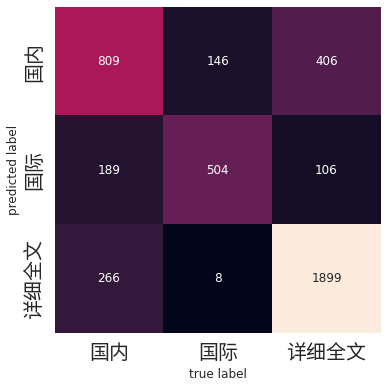

              precision    recall  f1-score   support

          国内       0.59      0.64      0.62      1264
          国际       0.63      0.77      0.69       658
        详细全文       0.87      0.79      0.83      2411

    accuracy                           0.74      4333
   macro avg       0.70      0.73      0.71      4333
weighted avg       0.76      0.74      0.75      4333



In [99]:
# Validation
def show_confusion_matrix(valid_y, predicted, size=1, font_prop=prop, trim_labels=False):
    mat = confusion_matrix(valid_y, predicted)
    plt.figure(figsize=(4*size, 4*size))
    f, ax = plt.subplots(1,1, figsize=(4*size,4*size))
    sns.set()
    target_labels = np.unique(valid_y)
    if(trim_labels):
        target_labels = [x[0:70] for x in target_labels]
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=target_labels,
                yticklabels=target_labels
               )
    ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font_prop);
    ax.set_yticklabels(ax.get_yticklabels(), fontproperties=font_prop);
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()

predicted_valid = clf_nb.predict(valid_X)
prediction_acc = np.mean(predicted_valid == valid_y)
prediction_f1_score = f1_score(valid_y, predicted_valid, average='weighted')
prediction_recall = recall_score(valid_y, predicted_valid, average='weighted')
print("Valid:\n========================================================")
print(f"Feature: {target} \t| Prediction accuracy: {prediction_acc}")
print(f"Feature: {target} \t| Prediction F1-score: {prediction_f1_score}")
print(f"Feature: {target} \t| Prediction recall: {prediction_recall}")
show_confusion_matrix(valid_y, predicted_valid, font_prop=prop,size=1.5)
print(classification_report(valid_y, predicted_valid))

In [100]:
clf_knn = KNeighborsClassifier(n_neighbors=5, metric="minkowski", p=2)
clf_knn = clf_knn.fit(train_X, train_y)

Valid:
Feature: tag 	| Prediction accuracy: 0.531502423263328
Feature: tag 	| Prediction F1-score: 0.5126262012040738
Feature: tag 	| Prediction recall: 0.531502423263328


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22269 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38469 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35814 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32454 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20840 missing from current font.
  font.set_

<Figure size 432x432 with 0 Axes>

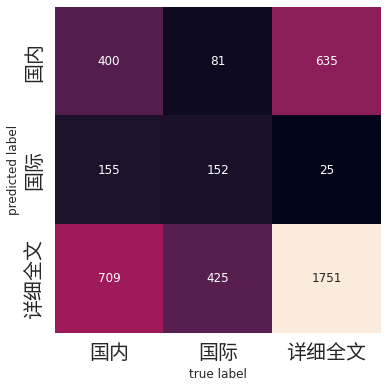

              precision    recall  f1-score   support

          国内       0.36      0.32      0.34      1264
          国际       0.46      0.23      0.31       658
        详细全文       0.61      0.73      0.66      2411

    accuracy                           0.53      4333
   macro avg       0.47      0.42      0.43      4333
weighted avg       0.51      0.53      0.51      4333



In [101]:
# Validation
def show_confusion_matrix(valid_y, predicted, size=1, font_prop=prop, trim_labels=False):
    mat = confusion_matrix(valid_y, predicted)
    plt.figure(figsize=(4*size, 4*size))
    f, ax = plt.subplots(1,1, figsize=(4*size,4*size))
    sns.set()
    target_labels = np.unique(valid_y)
    if(trim_labels):
        target_labels = [x[0:70] for x in target_labels]
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=target_labels,
                yticklabels=target_labels
               )
    ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font_prop);
    ax.set_yticklabels(ax.get_yticklabels(), fontproperties=font_prop);
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()

predicted_valid = clf_knn.predict(valid_X)
prediction_acc = np.mean(predicted_valid == valid_y)
prediction_f1_score = f1_score(valid_y, predicted_valid, average='weighted')
prediction_recall = recall_score(valid_y, predicted_valid, average='weighted')
print("Valid:\n========================================================")
print(f"Feature: {target} \t| Prediction accuracy: {prediction_acc}")
print(f"Feature: {target} \t| Prediction F1-score: {prediction_f1_score}")
print(f"Feature: {target} \t| Prediction recall: {prediction_recall}")
show_confusion_matrix(valid_y, predicted_valid, font_prop=prop,size=1.5)
print(classification_report(valid_y, predicted_valid))

In [72]:
clf_LR = LogisticRegression()
clf_LR = clf_LR.fit(train_X, train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Valid:
Feature: tag 	| Prediction accuracy: 0.8049849988460651
Feature: tag 	| Prediction F1-score: 0.8069617862549519
Feature: tag 	| Prediction recall: 0.8049849988460651


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22269 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38469 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35814 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32454 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20840 missing from current font.
  font.set_

<Figure size 432x432 with 0 Axes>

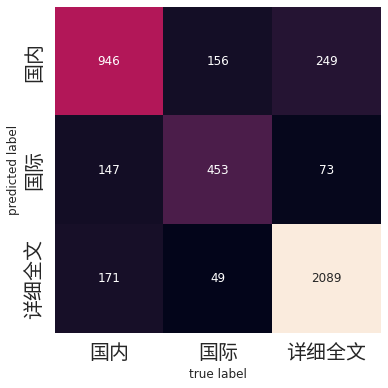

              precision    recall  f1-score   support

          国内       0.70      0.75      0.72      1264
          国际       0.67      0.69      0.68       658
        详细全文       0.90      0.87      0.89      2411

    accuracy                           0.80      4333
   macro avg       0.76      0.77      0.76      4333
weighted avg       0.81      0.80      0.81      4333

Valid:
Feature: tag 	| Prediction accuracy: 0.8049849988460651
Feature: tag 	| Prediction F1-score: 0.8069617862549519
Feature: tag 	| Prediction recall: 0.8049849988460651


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22269 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38469 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35814 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32454 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20840 missing from current font.
  font.set_

<Figure size 432x432 with 0 Axes>

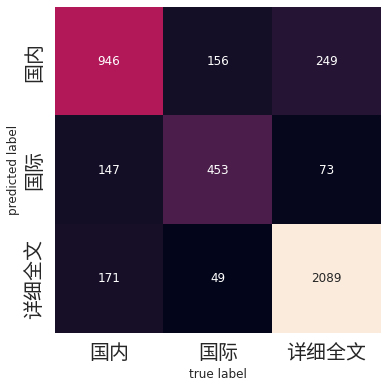

              precision    recall  f1-score   support

          国内       0.70      0.75      0.72      1264
          国际       0.67      0.69      0.68       658
        详细全文       0.90      0.87      0.89      2411

    accuracy                           0.80      4333
   macro avg       0.76      0.77      0.76      4333
weighted avg       0.81      0.80      0.81      4333



In [71]:
# Validation
def show_confusion_matrix(valid_y, predicted, size=1, font_prop=prop, trim_labels=False):
    mat = confusion_matrix(valid_y, predicted)
    plt.figure(figsize=(4*size, 4*size))
    f, ax = plt.subplots(1,1, figsize=(4*size,4*size))
    sns.set()
    target_labels = np.unique(valid_y)
    if(trim_labels):
        target_labels = [x[0:70] for x in target_labels]
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=target_labels,
                yticklabels=target_labels
               )
    ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font_prop);
    ax.set_yticklabels(ax.get_yticklabels(), fontproperties=font_prop);
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()

predicted_valid = clf_LR.predict(valid_X)
prediction_acc = np.mean(predicted_valid == valid_y)
prediction_f1_score = f1_score(valid_y, predicted_valid, average='weighted')
prediction_recall = recall_score(valid_y, predicted_valid, average='weighted')
print("Valid:\n========================================================")
print(f"Feature: {target} \t| Prediction accuracy: {prediction_acc}")
print(f"Feature: {target} \t| Prediction F1-score: {prediction_f1_score}")
print(f"Feature: {target} \t| Prediction recall: {prediction_recall}")
show_confusion_matrix(valid_y, predicted_valid, font_prop=prop,size=1.5)
print(classification_report(valid_y, predicted_valid))

In [102]:
from sklearn.tree import DecisionTreeClassifier
clf_dtc = DecisionTreeClassifier()
clf_dtc = clf_dtc.fit(train_X, train_y)

Valid:
Feature: tag 	| Prediction accuracy: 0.7447495961227787
Feature: tag 	| Prediction F1-score: 0.7464266906820648
Feature: tag 	| Prediction recall: 0.7447495961227787


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22269 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 38469 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35814 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32454 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20840 missing from current font.
  font.set_

<Figure size 432x432 with 0 Axes>

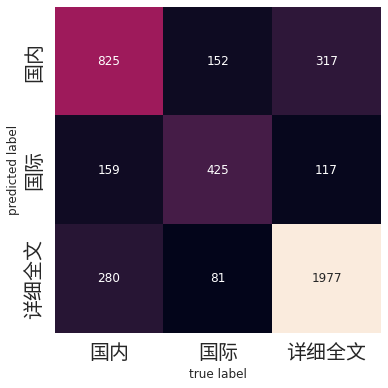

              precision    recall  f1-score   support

          国内       0.64      0.65      0.65      1264
          国际       0.61      0.65      0.63       658
        详细全文       0.85      0.82      0.83      2411

    accuracy                           0.74      4333
   macro avg       0.70      0.71      0.70      4333
weighted avg       0.75      0.74      0.75      4333



In [103]:
# Validation
def show_confusion_matrix(valid_y, predicted, size=1, font_prop=prop, trim_labels=False):
    mat = confusion_matrix(valid_y, predicted)
    plt.figure(figsize=(4*size, 4*size))
    f, ax = plt.subplots(1,1, figsize=(4*size,4*size))
    sns.set()
    target_labels = np.unique(valid_y)
    if(trim_labels):
        target_labels = [x[0:70] for x in target_labels]
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=target_labels,
                yticklabels=target_labels
               )
    ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font_prop);
    ax.set_yticklabels(ax.get_yticklabels(), fontproperties=font_prop);
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()

predicted_valid = clf_dtc.predict(valid_X)
prediction_acc = np.mean(predicted_valid == valid_y)
prediction_f1_score = f1_score(valid_y, predicted_valid, average='weighted')
prediction_recall = recall_score(valid_y, predicted_valid, average='weighted')
print("Valid:\n========================================================")
print(f"Feature: {target} \t| Prediction accuracy: {prediction_acc}")
print(f"Feature: {target} \t| Prediction F1-score: {prediction_f1_score}")
print(f"Feature: {target} \t| Prediction recall: {prediction_recall}")
show_confusion_matrix(valid_y, predicted_valid, font_prop=prop,size=1.5)
print(classification_report(valid_y, predicted_valid))